In [9]:
# Create GAN for MDP process of six sided die

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


class GAN:
    def __init__(self, seq_len=100):
        # self.P = np.random.uniform(0, 1, (6, 6))
        self.P = np.array([[0.5,0.5,0,0,0,0],[0,0.5,0.5,0,0,0],[0,0,0.5,0.5,0,0],[0,0,0,0.5,0.5,0],[0,0,0,0,0.5,0.5],[0.5,0,0,0,0,0.5]])
        # print(self.P, np.sum(self.P, axis=1, keepdims=True))
        # self.P = self.P / np.sum(self.P, axis=1, keepdims=True)
        self.seq_len = seq_len
        # print(self.P)
        self.build_generator()
        self.build_discriminator()
        self.build_gan()
        print(self.P)
    
    def generate_real_samples(self, n_samples):
        X_total = []
        for i in range(n_samples):
            X = [np.random.choice(6)]
            for i in range(1, self.seq_len):
                X.append(np.random.choice(6, p=self.P[X[i - 1]]))
            X = np.array(X)
            # X = tf.keras.utils.to_categorical(X, num_classes=6)
            X_total.append(X)
        X = np.array(X_total) / 5
        y = np.ones((n_samples, 1)) * 0.9
        # print(X.shape, y.shape)
        return X, y
    
    def generate_fake_samples(self, n_samples):
        X = self.generator.predict(np.random.normal(0, 1, (n_samples, 100)))
        y = np.zeros((n_samples, 1))
        return X, y
    
    def calculate_P(self, n_samples):
        X, _ = self.generate_fake_samples(n_samples)
        # X = np.argmax(X, axis=2)
        X = X * 5
        X = np.rint(X)
        X = X.astype(np.int64)
        P = np.zeros((6, 6))
        for i in range(n_samples):
            for j in range(self.seq_len - 1):
                P[X[i, j], X[i, j + 1]] += 1
                
        P = P / np.sum(P, axis=1, keepdims=True)
        return P
    
    def calculate_P_real(self, n_samples):
        X, _ = self.generate_real_samples(n_samples)
        X = np.argmax(X, axis=2)
        P = np.zeros((6, 6))
        for i in range(n_samples):
            for j in range(self.seq_len - 1):
                P[X[i, j], X[i, j + 1]] += 1
                
        P = P / np.sum(P, axis=1, keepdims=True)
        return P
    def build_generator(self):
        self.generator = tf.keras.models.Sequential([
            tf.keras.layers.Dense(25 * 200, input_shape=(100,)),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Reshape((25, 200)), 
            tf.keras.layers.Conv1DTranspose(100, 3, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv1DTranspose(50, 3, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv1DTranspose(1, 3, strides=1, padding='same', activation='sigmoid'),
        ])
    def summarize_generator(self):
        self.generator.summary()
        # tf.keras.utils.plot_model(self.generator, show_shapes=True, dpi=64)

    def build_discriminator(self):
        self.discriminator = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(50, 3, strides=2, padding='same', input_shape=(self.seq_len, 1)),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv1D(100, 3, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv1D(200, 3, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1, activation='sigmoid'),
        ])
        self.discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    def summarize_discriminator(self):
        self.discriminator.summary()
        # tf.keras.utils.plot_model(self.discriminator, show_shapes=True, dpi=64)
    
    def build_gan(self):
        self.discriminator.trainable = False
        self.gan = tf.keras.models.Sequential([
            self.generator,
            self.discriminator,
        ])
        self.gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam())
        
    def train(self, epochs = 10, batch_size = 128):
        l1_hist = []
        l2_hist = []
        l3_hist = []
        ac1_hist = []
        ac2_hist = []
        total = 100000//batch_size
        train_data_x, train_data_y = self.generate_real_samples(10000)
        for i in range(epochs):
            print("Iteration:", i)
            # Train the discriminator
            
            for k in range(total):
                print(k,"/",total,end="\r")
                idx = np.random.randint(0, 10000, batch_size//2)
                X_real, y_real = train_data_x[idx], train_data_y[idx]
                # X_real, y_real = self.generate_real_samples(batch_size//2)
                X_fake, y_fake = self.generate_fake_samples(batch_size//2)
                

                # Train the discriminator
                l1, ac1 = self.discriminator.train_on_batch(X_real, y_real)
                
                l2, ac2 = self.discriminator.train_on_batch(X_fake, y_fake)

                X_fake = np.random.normal(0, 1, (batch_size, 100))
                y_fake = np.ones((batch_size, 1))
                l3 = self.gan.train_on_batch(X_fake, y_fake)
                
                l1_hist.append(l1)
                l2_hist.append(l2)
                l3_hist.append(l3)
                ac1_hist.append(ac1)
                ac2_hist.append(ac2)
                
            # Show plots of the losses and accuracies
            calc_p = self.calculate_P(100000)
            print(calc_p)
            print("Loss:",np.mean(np.abs(calc_p - self.P)))
            if i % 10 >= 0:
                plt.figure(figsize=(10, 10))
                plt.subplot(2, 1, 1)
                plt.plot(l1_hist, label="Discriminator(Real)")
                plt.plot(l2_hist, label="Discriminator(Fake)")
                plt.plot(l3_hist, label="Generator")
                plt.legend()
                plt.title("Losses")
                plt.subplot(2, 1, 2)
                plt.plot(ac1_hist, label="Accuracy(Real)")
                plt.plot(ac2_hist, label="Accuracy(fake)")
                plt.legend()
                plt.title("Accuracies")
                plt.show()
                l1_hist = []
                l2_hist = []
                l3_hist = []
                ac1_hist = []
                ac2_hist = []

In [10]:
print("Hello")
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
a = np.rint(np.array([2.3,3.4,5.8]))
print(a.astype(np.int64))

Hello
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[2 3 6]


In [11]:
print("DADAD")

DADAD


In [12]:
gan = GAN()
gan.summarize_generator()
gan.summarize_discriminator()

[[0.5 0.5 0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.5 0.5]
 [0.5 0.  0.  0.  0.  0.5]]


In [13]:
print(gan.generate_real_samples(1))

(array([[0. , 0. , 0.2, 0.2, 0.2, 0.2, 0.4, 0.6, 0.8, 0.8, 1. , 1. , 1. ,
        0. , 0. , 0.2, 0.4, 0.4, 0.4, 0.4, 0.6, 0.8, 1. , 1. , 0. , 0. ,
        0.2, 0.4, 0.6, 0.6, 0.8, 0.8, 0.8, 1. , 1. , 0. , 0.2, 0.4, 0.6,
        0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 1. , 0. , 0. , 0.2, 0.4, 0.4,
        0.4, 0.4, 0.4, 0.4, 0.6, 0.8, 1. , 1. , 1. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.6, 0.6, 0.6,
        0.6, 0.6, 0.8, 1. , 1. , 1. , 1. , 1. , 0. , 0.2, 0.4, 0.4, 0.4,
        0.4, 0.4, 0.6, 0.8, 0.8, 1. , 0. , 0.2, 0.2]]), array([[0.9]]))


Iteration: 0
[[0.53221495 0.28319895 0.17094721 0.01037287 0.00192683 0.00133919]
 [0.07314027 0.30089412 0.57210186 0.0477019  0.00422813 0.00193371]
 [0.01397788 0.06840863 0.56929904 0.30454528 0.04199104 0.00177814]
 [0.01993492 0.02772256 0.12471715 0.42337203 0.31777926 0.08647407]
 [0.05578395 0.039972   0.03823021 0.08575857 0.33244688 0.44780839]
 [0.22751834 0.02986092 0.0201554  0.02364705 0.06067696 0.63814134]]
Loss: 0.07569093084182803


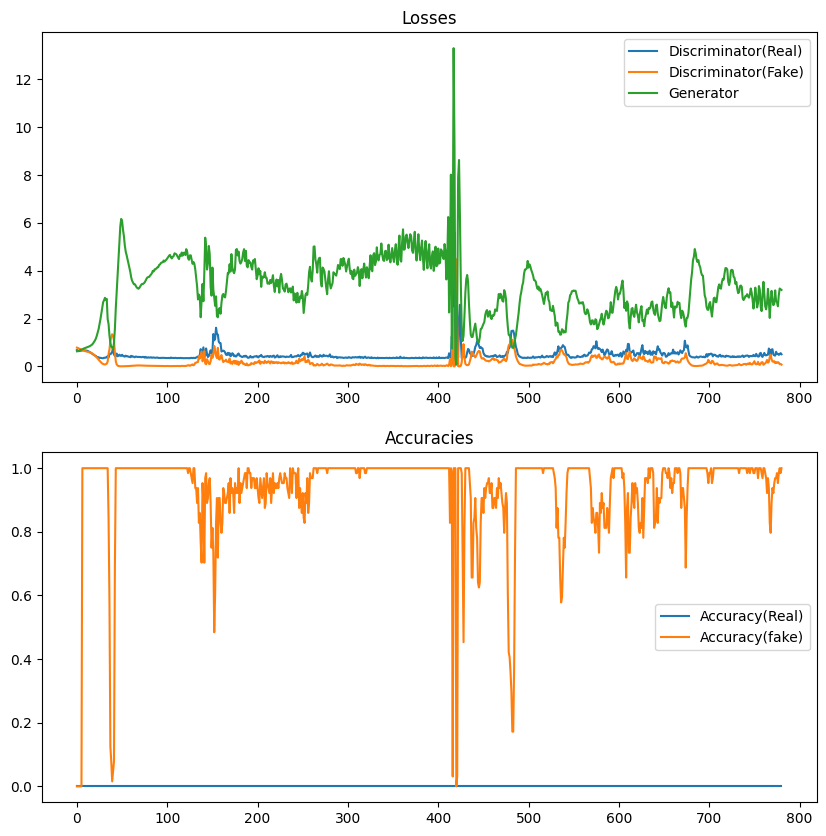

Iteration: 1
[[5.44694286e-01 4.29204299e-01 2.24463582e-02 2.36702643e-03
  9.39640826e-04 3.48389129e-04]
 [4.29326146e-02 4.04760523e-01 5.14749221e-01 3.27246001e-02
  3.56005564e-03 1.27298564e-03]
 [2.02156168e-02 1.35187261e-02 3.55294060e-01 5.78407522e-01
  2.82985219e-02 4.26555398e-03]
 [1.67852967e-02 6.38787626e-03 1.32945859e-02 4.45215941e-01
  4.93049412e-01 2.52668879e-02]
 [2.61795063e-02 7.26927299e-03 6.49425882e-03 2.15867881e-02
  4.76309200e-01 4.62160973e-01]
 [4.70801379e-01 2.42967993e-02 1.44640296e-02 1.44361967e-02
  3.68073499e-02 4.39194245e-01]]
Loss: 0.029111664817158316


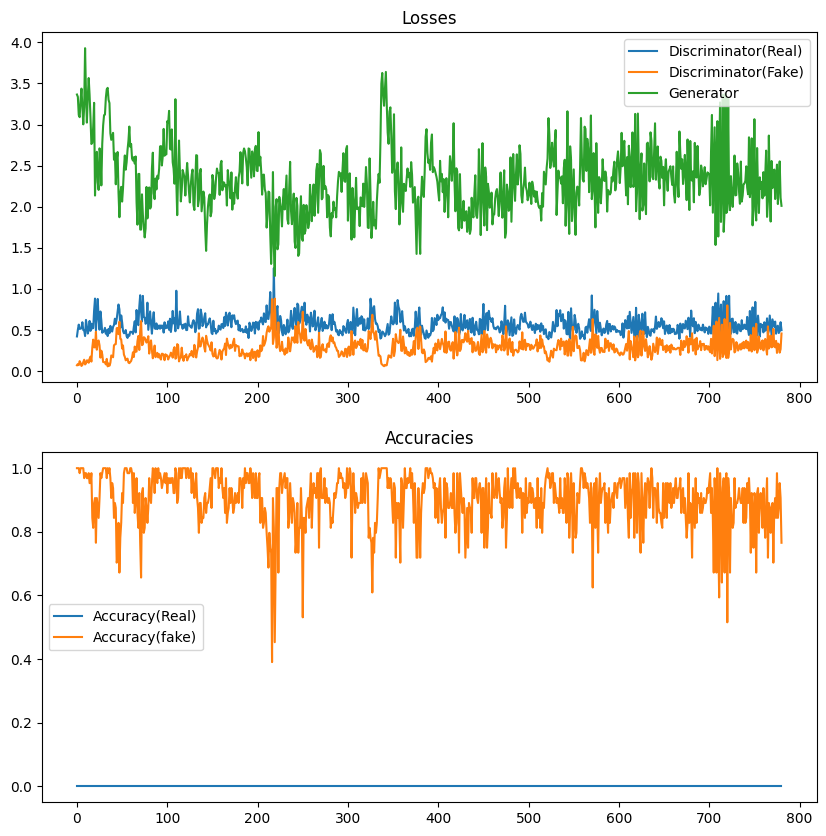

Iteration: 2
[[4.48563818e-01 5.29404010e-01 1.95312673e-02 1.76698489e-03
  4.58858343e-04 2.75061493e-04]
 [2.28997012e-02 4.70845493e-01 4.74777462e-01 2.91982885e-02
  1.73987830e-03 5.39176350e-04]
 [1.06641270e-02 1.88377219e-02 4.50146244e-01 4.96284004e-01
  2.27776042e-02 1.29029868e-03]
 [1.19615539e-02 5.22362292e-03 2.04914278e-02 3.77706059e-01
  5.68754096e-01 1.58632402e-02]
 [1.62101529e-02 4.34086702e-03 3.62501621e-03 1.87009215e-02
  5.00038135e-01 4.57084907e-01]
 [4.09089076e-01 1.35148394e-02 7.94679534e-03 7.78545015e-03
  3.16454592e-02 5.30018380e-01]]
Loss: 0.023083496454852


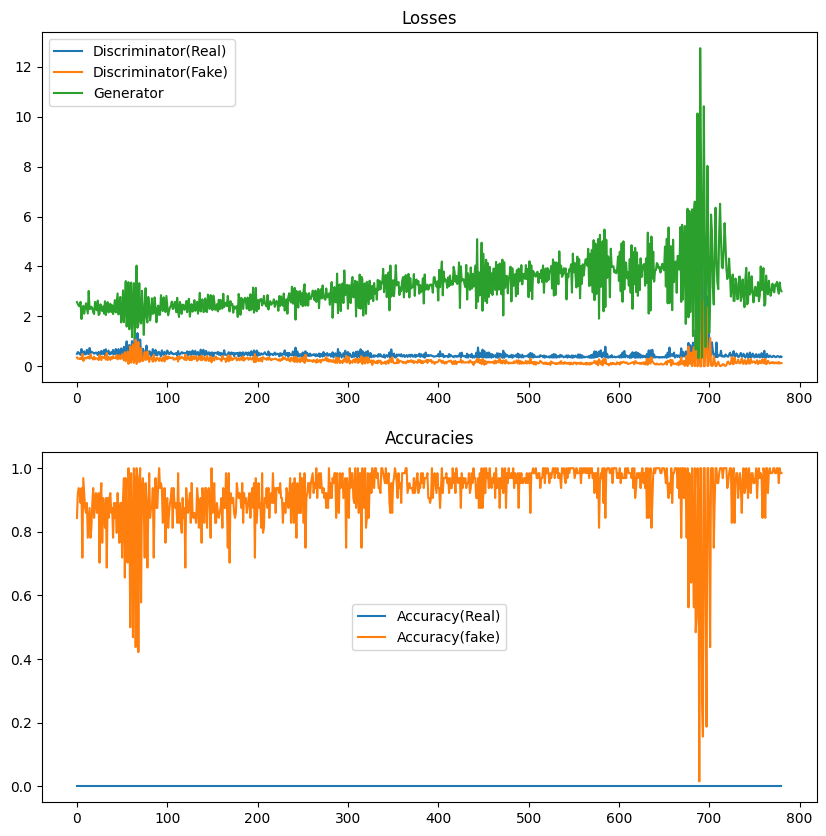

Iteration: 3
[[4.47260745e-01 5.32136608e-01 1.82289924e-02 1.59196661e-03
  5.71158633e-04 2.10529462e-04]
 [1.76438343e-02 4.64482220e-01 4.72868831e-01 4.15830497e-02
  2.78947878e-03 6.32586717e-04]
 [7.68355490e-03 4.16280024e-02 4.88307089e-01 4.29552703e-01
  3.10168962e-02 1.81175410e-03]
 [1.09686171e-02 5.60432355e-03 2.05949063e-02 2.97873853e-01
  6.39081062e-01 2.58772385e-02]
 [1.45712945e-02 4.09454083e-03 3.27691823e-03 1.57906578e-02
  3.94542755e-01 5.67723834e-01]
 [3.39206479e-01 1.02119990e-02 6.08238748e-03 6.12998331e-03
  4.73147422e-02 5.91054409e-01]]
Loss: 0.03699474029209106


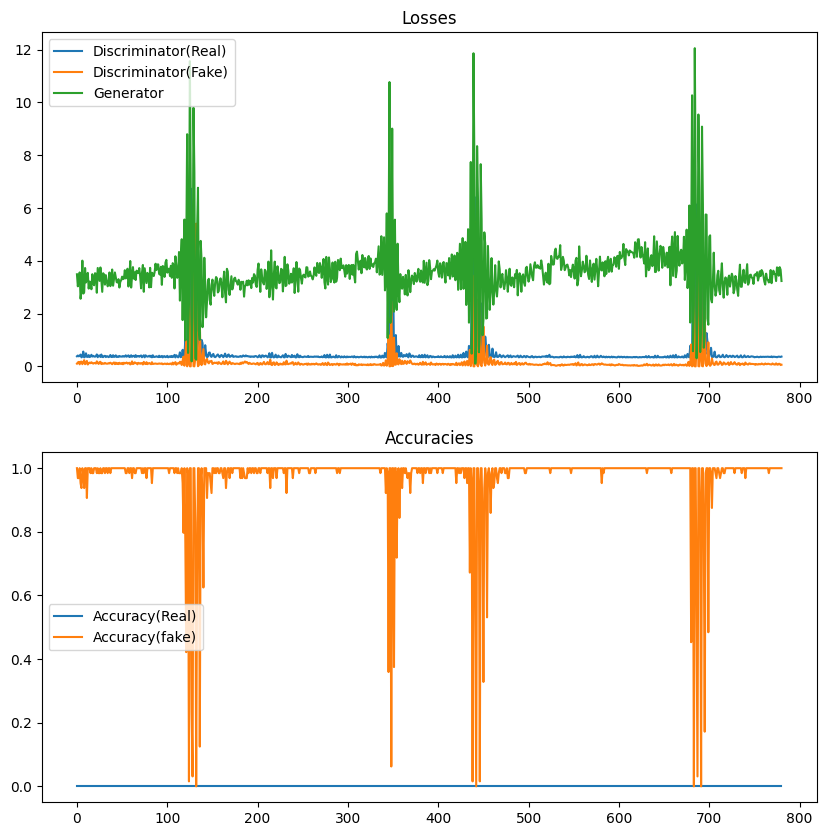

Iteration: 4
[[4.83465597e-01 5.04184840e-01 1.05790191e-02 1.03921931e-03
  5.00865606e-04 2.30459635e-04]
 [1.38830786e-02 4.72861938e-01 4.88240260e-01 2.32090585e-02
  1.36875422e-03 4.36910526e-04]
 [6.51960631e-03 3.76155633e-02 4.87108379e-01 4.50079199e-01
  1.77132181e-02 9.64034956e-04]
 [8.69640120e-03 4.07506972e-03 3.13264255e-02 3.54329358e-01
  5.72385427e-01 2.91873190e-02]
 [1.27769825e-02 3.06421029e-03 2.74865789e-03 2.44310376e-02
  4.45857623e-01 5.11121488e-01]
 [4.58362440e-01 1.11805808e-02 6.65702072e-03 6.88487767e-03
  6.81508149e-02 4.48764266e-01]]
Loss: 0.022829496706229777


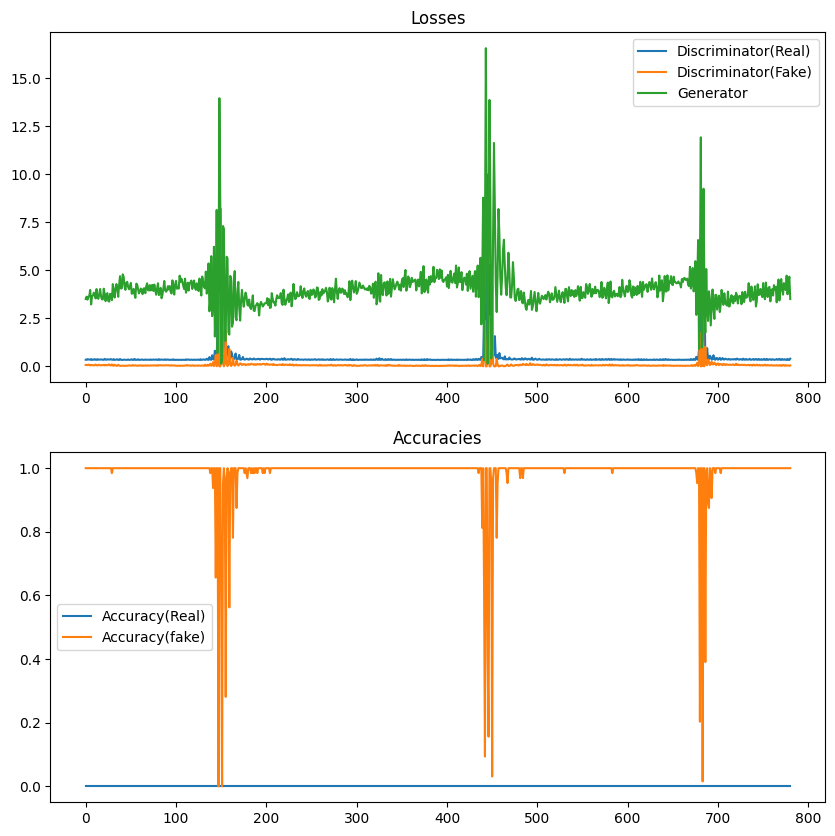

Iteration: 5
[[4.91762766e-01 4.94601848e-01 1.17969424e-02 9.59132158e-04
  6.29630032e-04 2.49680875e-04]
 [1.63724353e-02 3.70170116e-01 5.81680462e-01 2.97513043e-02
  1.55647315e-03 4.69208654e-04]
 [5.26830201e-03 1.69568762e-02 5.21129066e-01 4.20436377e-01
  3.53598205e-02 8.49558515e-04]
 [5.79619952e-03 3.36944284e-03 7.17848058e-02 4.60339723e-01
  4.45699956e-01 1.30098729e-02]
 [1.00484251e-02 3.36225506e-03 3.18889139e-03 3.66691949e-02
  4.78883249e-01 4.67847985e-01]
 [4.76536323e-01 1.29534702e-02 7.52759395e-03 7.90183696e-03
  5.38094119e-02 4.41271364e-01]]
Loss: 0.025136127368406688


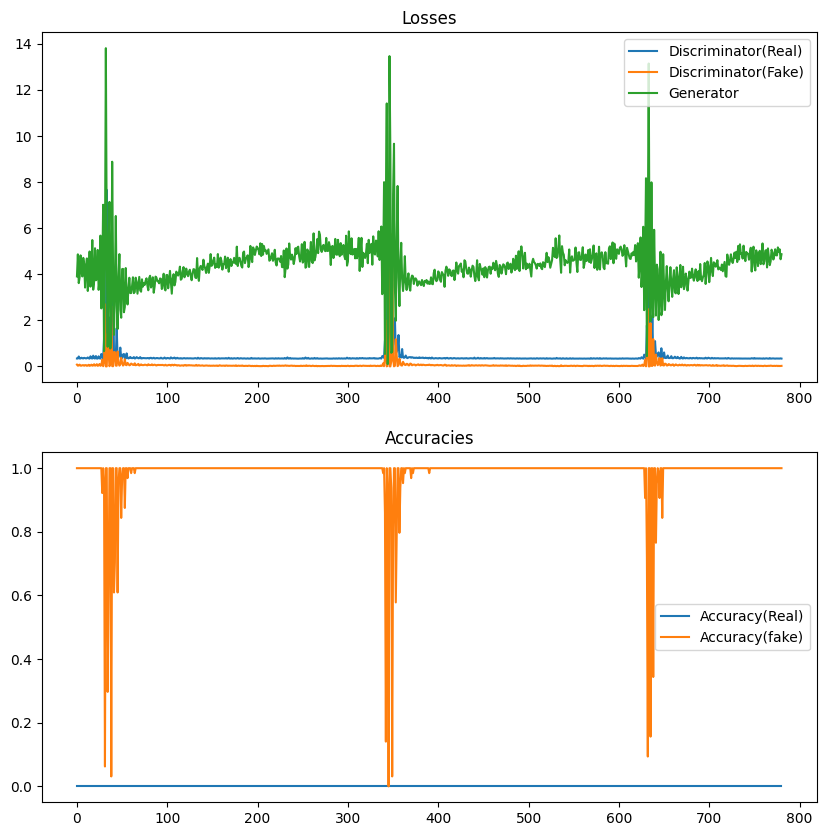

Iteration: 6
[[5.17966896e-01 4.72924634e-01 7.86990871e-03 7.59387638e-04
  3.31597277e-04 1.47575725e-04]
 [1.56776521e-02 4.27053265e-01 5.36974938e-01 1.88201431e-02
  1.04681459e-03 4.27187699e-04]
 [6.72552277e-03 1.63652313e-02 4.64060449e-01 4.97340277e-01
  1.45740399e-02 9.34480592e-04]
 [6.32842796e-03 3.26753404e-03 2.92851324e-02 4.63489014e-01
  4.88881333e-01 8.74855888e-03]
 [1.01398889e-02 3.06392101e-03 2.75128699e-03 2.82780430e-02
  4.89971766e-01 4.65795094e-01]
 [4.59231994e-01 1.03655865e-02 6.16118085e-03 6.29856355e-03
  6.02095148e-02 4.57733161e-01]]
Loss: 0.017417723031812042


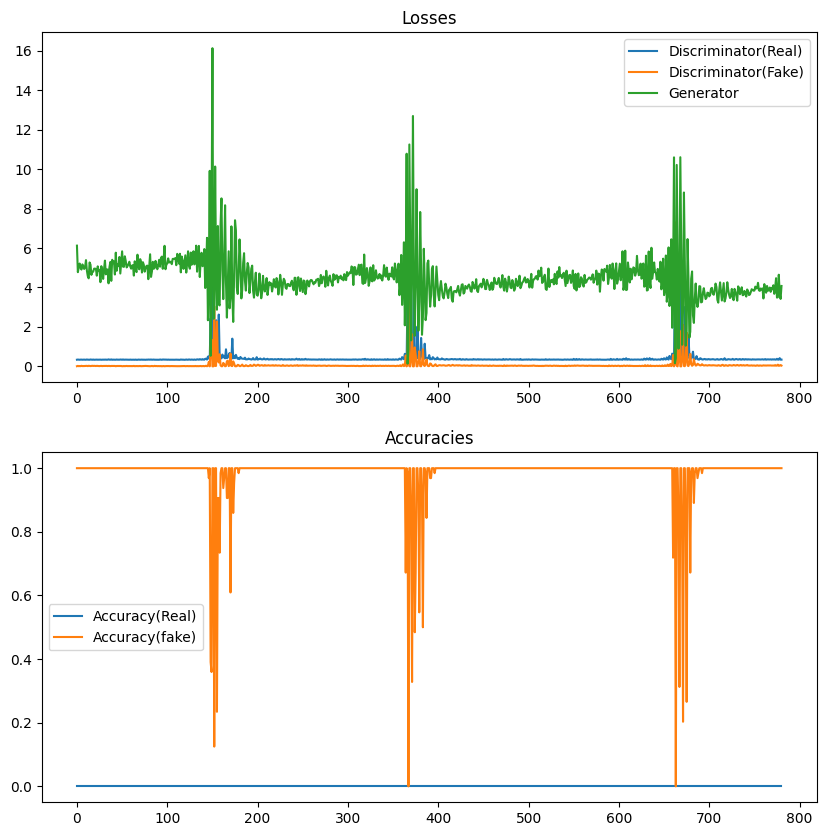

Iteration: 7
[[4.97606915e-01 4.91857320e-01 9.08083548e-03 9.25519965e-04
  3.51255359e-04 1.78154696e-04]
 [1.49996910e-02 4.64057125e-01 5.04903993e-01 1.49288892e-02
  7.49212169e-04 3.61089370e-04]
 [6.84421455e-03 2.16533974e-02 4.12276198e-01 5.39695288e-01
  1.83074578e-02 1.22344416e-03]
 [5.52957357e-03 3.19616367e-03 2.72690979e-02 4.85523448e-01
  4.69113006e-01 9.36871091e-03]
 [1.09449645e-02 2.97900441e-03 2.72329588e-03 3.02758903e-02
  4.13104807e-01 5.39972038e-01]
 [3.64881144e-01 8.46848267e-03 4.99466539e-03 5.03034511e-03
  4.07888588e-02 5.75836504e-01]]
Loss: 0.022310002070814357


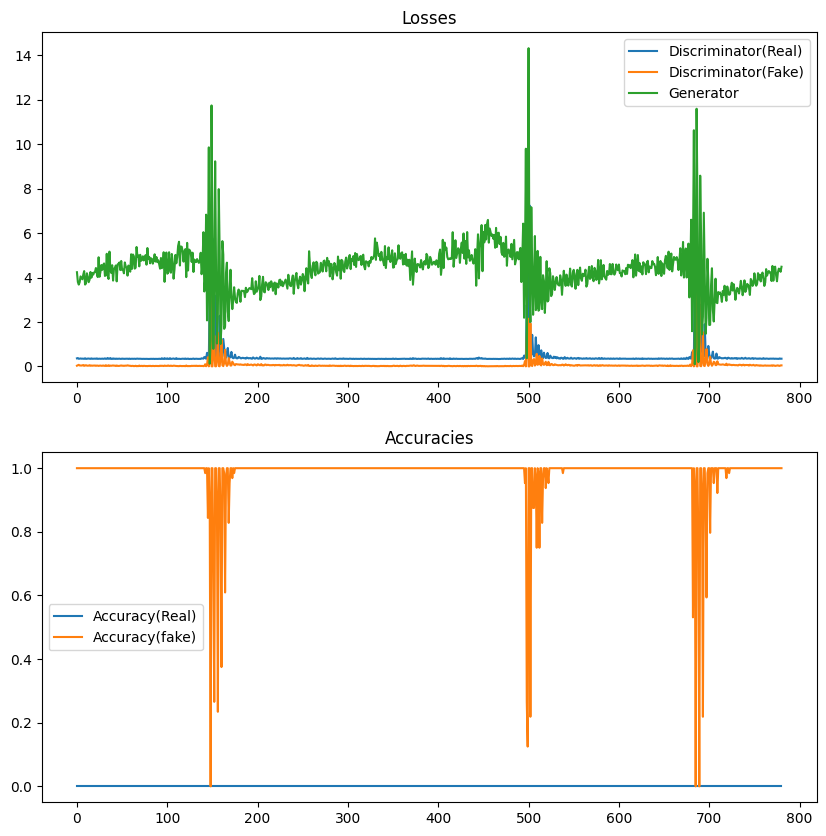

Iteration: 8
[[4.88346950e-01 4.74131892e-01 3.63463540e-02 7.50000989e-04
  2.67150748e-04 1.57651923e-04]
 [1.50214890e-02 4.74977489e-01 4.87597756e-01 2.17422711e-02
  4.61113731e-04 1.99881918e-04]
 [6.57342896e-03 3.60178821e-02 4.17833121e-01 5.02435793e-01
  3.65670331e-02 5.72742190e-04]
 [5.38311577e-03 3.19166671e-03 3.91120985e-02 5.06883442e-01
  4.35797951e-01 9.63172542e-03]
 [1.14928154e-02 3.14312036e-03 3.18897490e-03 2.94858594e-02
  3.82024603e-01 5.70664627e-01]
 [3.29811135e-01 7.77599042e-03 4.65529615e-03 4.83275460e-03
  3.49648324e-02 6.17959991e-01]]
Loss: 0.028304394578658933


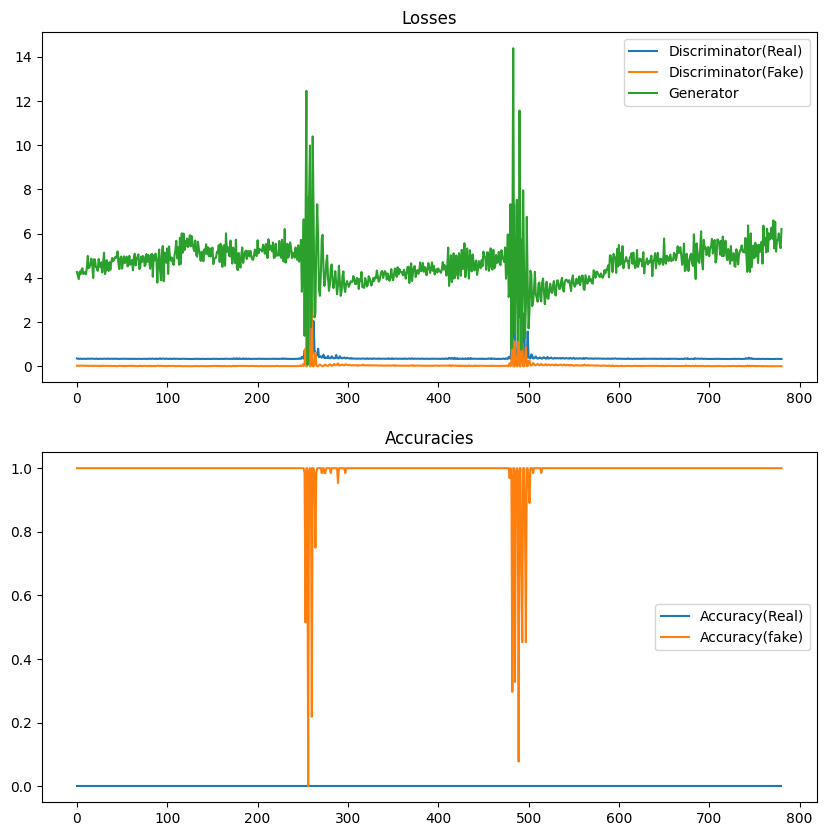

Iteration: 9
[[4.96593401e-01 4.95550136e-01 6.91913890e-03 6.45338415e-04
  2.18342727e-04 7.36422215e-05]
 [1.33718318e-02 5.17673880e-01 4.56238761e-01 1.21524784e-02
  4.26392462e-04 1.36656731e-04]
 [6.94684171e-03 2.46292586e-02 3.90845970e-01 5.54786452e-01
  2.22533818e-02 5.38095526e-04]
 [5.77869074e-03 2.96412419e-03 3.08274922e-02 4.90185055e-01
  4.56923798e-01 1.33208402e-02]
 [1.17473415e-02 3.08800611e-03 2.99936508e-03 2.65050422e-02
  3.98352101e-01 5.57308144e-01]
 [3.38531436e-01 7.67461589e-03 4.67621831e-03 4.81195212e-03
  3.73814686e-02 6.06924310e-01]]
Loss: 0.026487741188076352


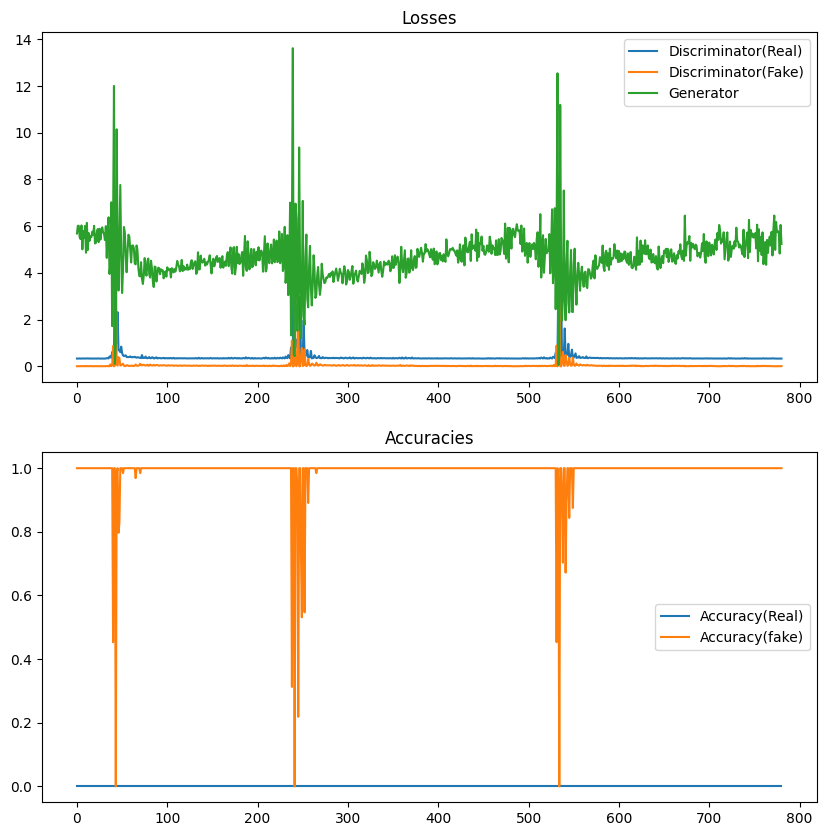

In [14]:
tf.keras.utils.disable_interactive_logging()
gan.train(epochs=10)

In [ ]:
x = (gan.generator.predict(np.random.normal(0, 1, (1, 100))))*5 + 1
x = np.rint(x)
x = x.astype(np.int64)
print(x)
print((gan.generate_real_samples(1)[0]))

In [ ]:
x = gan.generator.predict(np.random.normal(0, 1, (10000, 100))).flatten()
y = np.ones(x.shape)
print(x.min(),x.max(), x.mean())
fig = plt.figure(figsize=(100, 100))
ax = fig.subplots()
vals = ax.hist(x, bins=1000, alpha=0.5, label="Generated", range=(-0.5,1.5))
ax.set_xlim([-0.5,1.5])
ax.set_ylim([0, vals[0].max() + 10000])
ax.set_xticks(np.arange(-0.5, 1.5, (1.5+0.5)/100))   
fig.show()

In [ ]:
print(np.argmin(x))

In [ ]:
print(x[42703])
